## 3.基于ARIMA回归模型的股票价格预测

原理背景：
* 当一个自回归过程中：
$$
y_{t} = by_{t-1} + a + \epsilon _{t} 
$$
* 如果滞后项系数b为1，就称为单位根。
* 当单位根存在时，自变量和因变量之间的关系具有欺骗性，因为残差序列的任何误差都不会随着样本量（即时期数）增大而衰减，
* 也就是说模型中的残差的影响是永久的。这种回归又称作伪回归。
* ADF检验就是判断序列是否存在单位根：如果序列平稳，就不存在单位根；否则，就会存在单位根。

In [1]:
%matplotlib inline 
import pandas as pd
import datetime
import matplotlib.pylab as plt
from matplotlib.pylab import style
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
#读数据
stock = pd.read_csv('./data_stock1.csv', index_col=0, parse_dates=[0],encoding='gbk')  

In [3]:
stock

,开盘价,最高点,最低点,收盘价
日期,,,,
2000-01-03,6.498,6.603,6.498,6.548
2000-01-04,6.530,6.548,6.485,6.485
2000-01-05,6.521,6.599,6.508,6.599
2000-01-06,6.558,6.585,6.540,6.549
2000-01-07,6.545,6.595,6.504,6.504
...,...,...,...,...
2016-07-25,1.584,1.584,1.554,1.571
2016-07-26,1.559,1.587,1.549,1.563
2016-07-27,1.570,1.570,1.511,1.515


In [4]:
#选取每周的平均数据进行重新选样，以周一作为第一天，注意并不是选取周一的数据！！！！
stock['收盘价'].resample('w-mon').mean()

日期
2000-01-03    6.54800
2000-01-10    6.53900
2000-01-17    6.66300
2000-01-24    6.73720
2000-01-31    6.67280
               ...   
2016-07-04    1.47050
2016-07-11    1.38780
2016-07-18    1.53860
2016-07-25    1.56880
2016-08-01    1.51175
Freq: W-MON, Name: 收盘价, Length: 866, dtype: float64

In [5]:
stock_week = stock['收盘价'].resample('W-MON').mean()
stock_week.describe()

count    866.000000
mean       3.634347
std        1.243097
min        1.387800
25%        2.529713
50%        3.782325
75%        4.574300
max        6.737200
Name: 收盘价, dtype: float64

In [6]:
# 训练集选取00年到14年
stock_train = stock_week['2000':'2014']

<Figure size 7200x4800 with 0 Axes>

Text(0.5, 1.0, '股票收盘价')

Text(0.5, 0, '时间')

Text(0, 0.5, '股票收盘价')

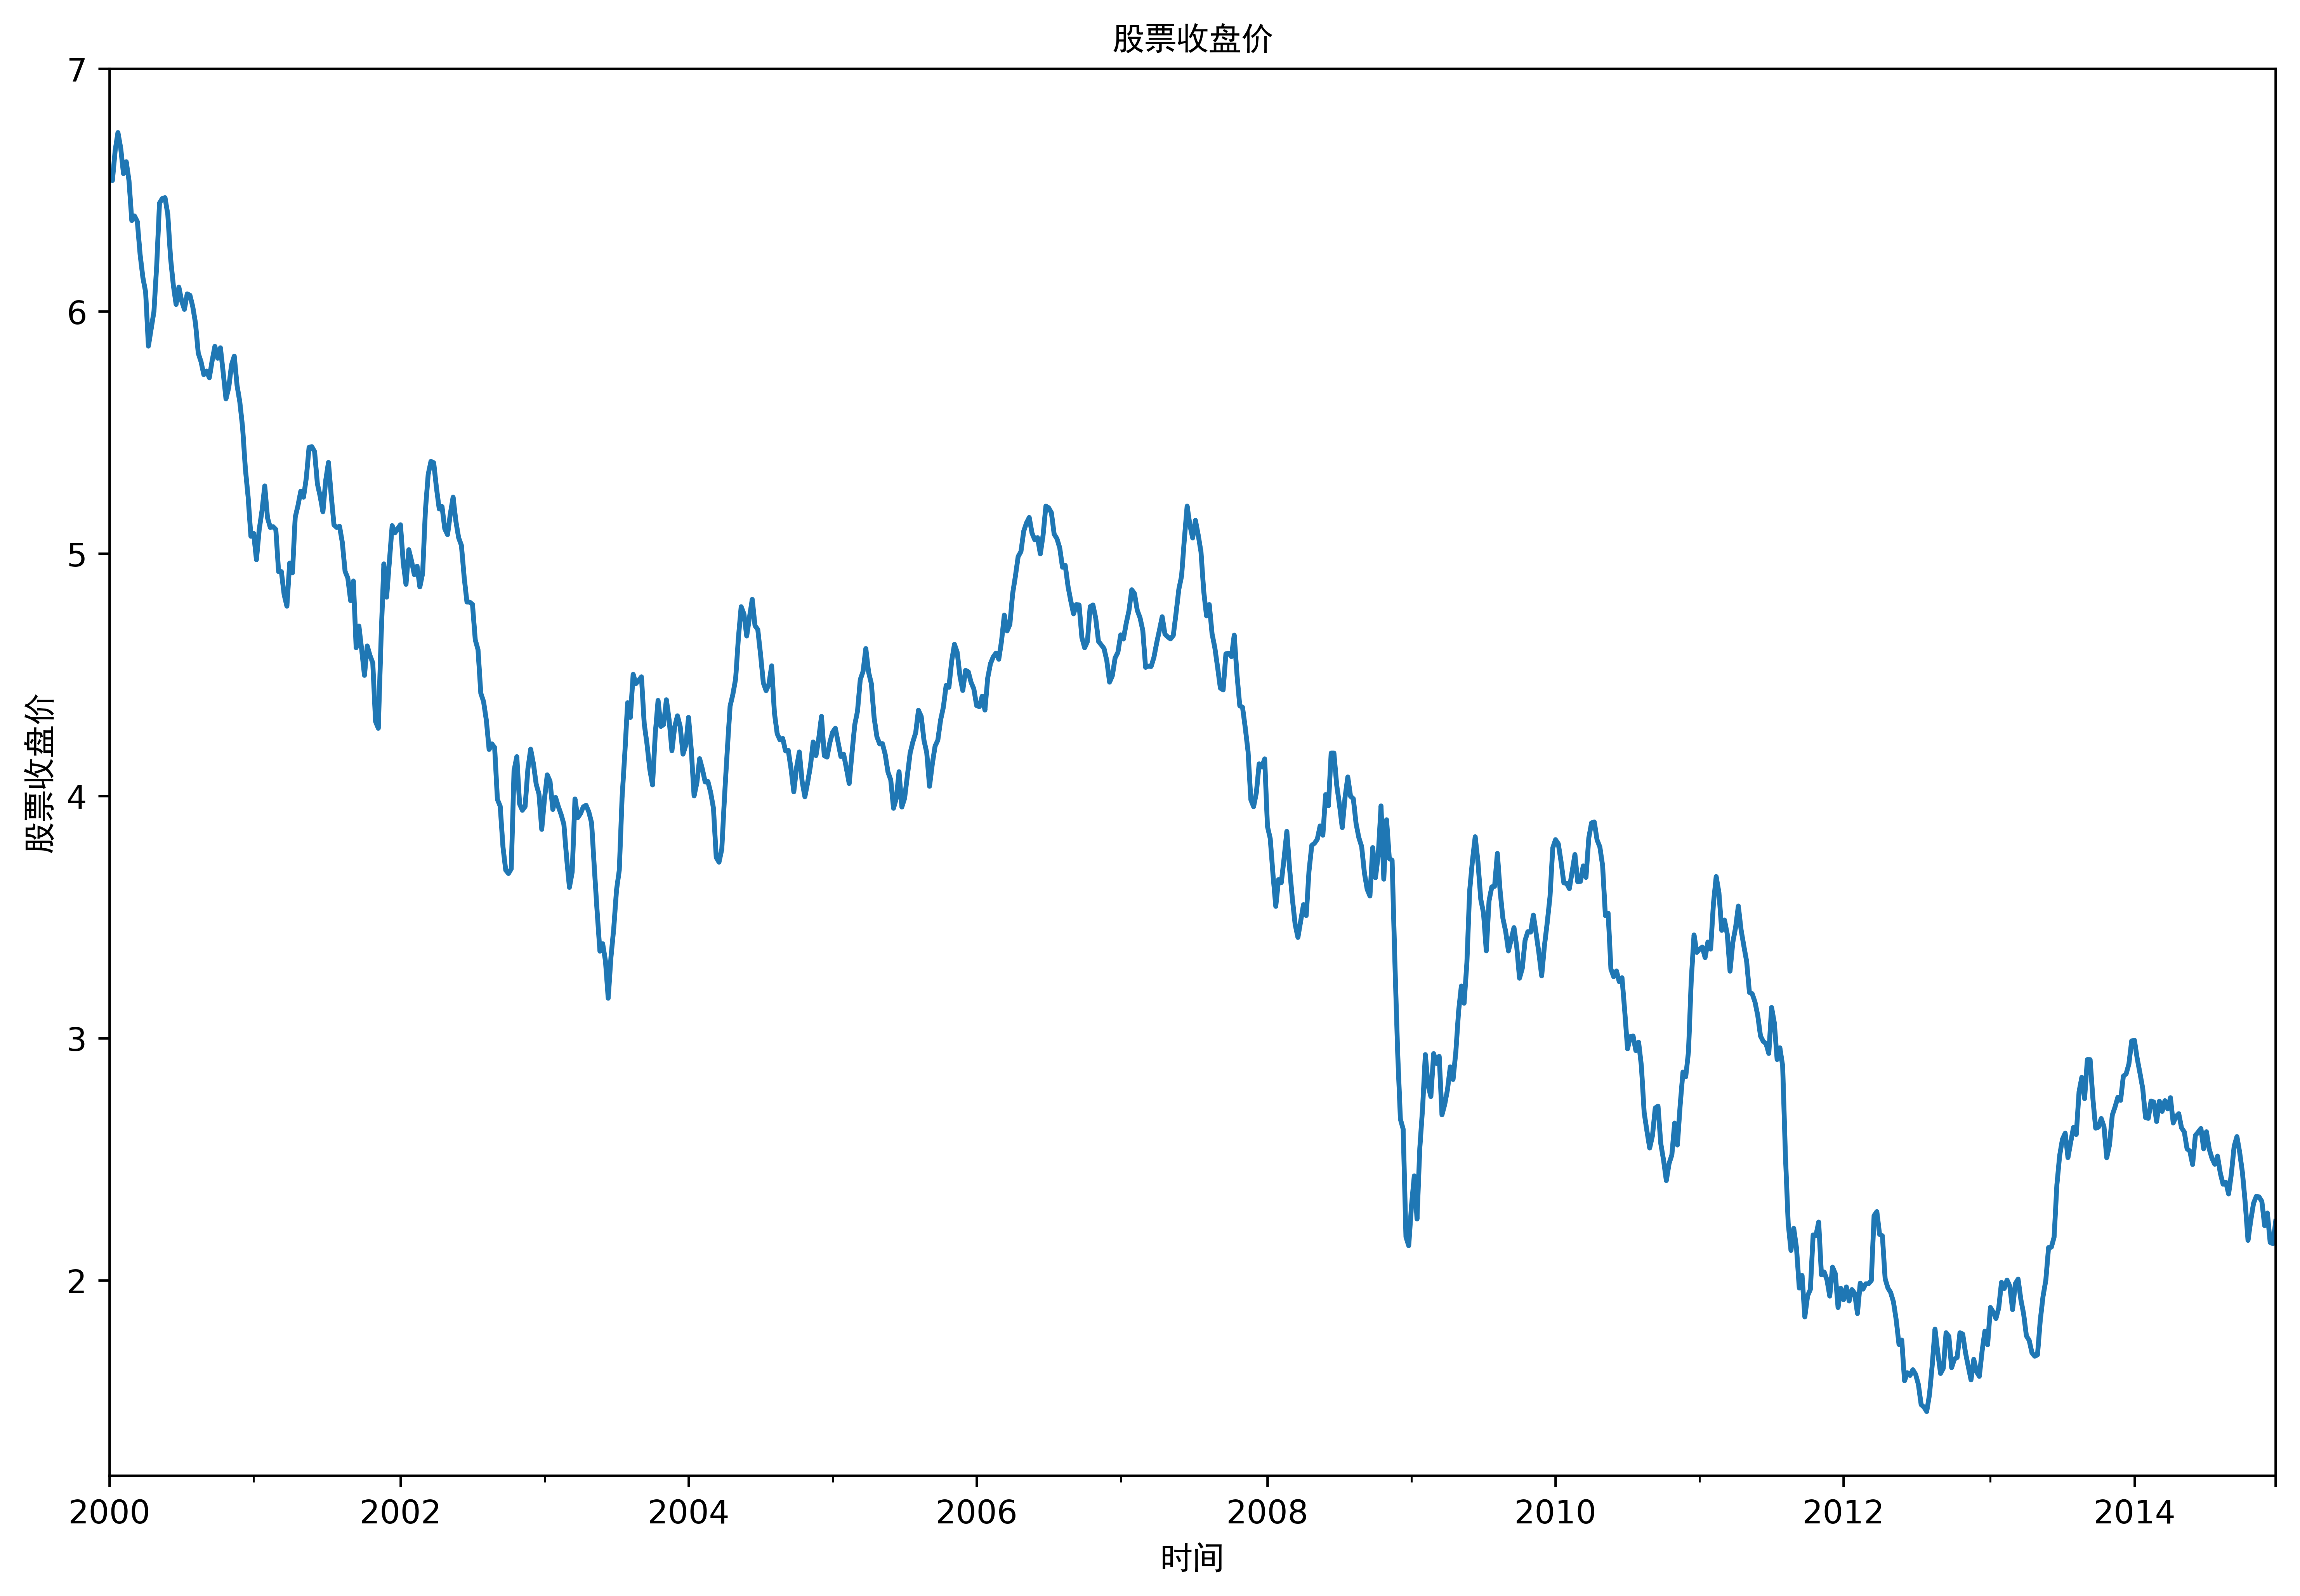

In [7]:
#不设字体会出现中文乱码，画个图
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf')
plt.figure(figsize=(12,8),dpi=600)
stock_train.plot()
plt.title('股票收盘价',fontproperties=myfont)
plt.xlabel('时间',fontproperties=myfont)
plt.ylabel('股票收盘价',fontproperties=myfont)

adfuller函数返回值：
* adf ：测试统计
* pvalue 
* usedlag ：使用的滞后阶数
* nobs ：用于ADF回归的观察数和临界值的计算
* critical values：在99%，95%，90%置信区间下的临界的ADF检验的值。如果第一个值比第五个值小证明平稳，反之证明不平稳。
* icbest ：如果autolag不是None，则最大化信息标准。
* resstore ：一个虚拟类，其结果作为属性附加

In [8]:
# 进行adf检验
from statsmodels.tsa.stattools import adfuller 
dftest = adfuller(stock_train)
dftest[1]
dftest[4]
dftest[0]
#因为Pvalue不小于0.05，且adf比critical values的值大，所以时间序列不平稳，因此要做一阶差分

0.2261027835971947

{'1%': -3.438750669890019, '5%': -2.8652477937238703, '10%': -2.56874438754281}

-2.146836965520035

In [9]:
# 开始做一阶差分
stock_diff_1 = stock_train.diff()
stock_diff_1

日期
2000-01-03       NaN
2000-01-10   -0.0090
2000-01-17    0.1240
2000-01-24    0.0742
2000-01-31   -0.0644
               ...  
2014-12-01   -0.1001
2014-12-08    0.0521
2014-12-15   -0.1214
2014-12-22   -0.0050
2014-12-29    0.0923
Freq: W-MON, Name: 收盘价, Length: 783, dtype: float64

In [10]:
# 因为第一次的数据没有前一项，所以要drop掉。
#其实第一个数据只是第一周周一的数据，并不是平均值，与其他数据类型不同，并没有意义
stock_diff = stock_diff_1.dropna()
stock_diff

日期
2000-01-10   -0.0090
2000-01-17    0.1240
2000-01-24    0.0742
2000-01-31   -0.0644
2000-02-07   -0.1052
               ...  
2014-12-01   -0.1001
2014-12-08    0.0521
2014-12-15   -0.1214
2014-12-22   -0.0050
2014-12-29    0.0923
Freq: W-MON, Name: 收盘价, Length: 782, dtype: float64

<Figure size 7200x4800 with 0 Axes>

Text(0.5, 1.0, '一阶差分')

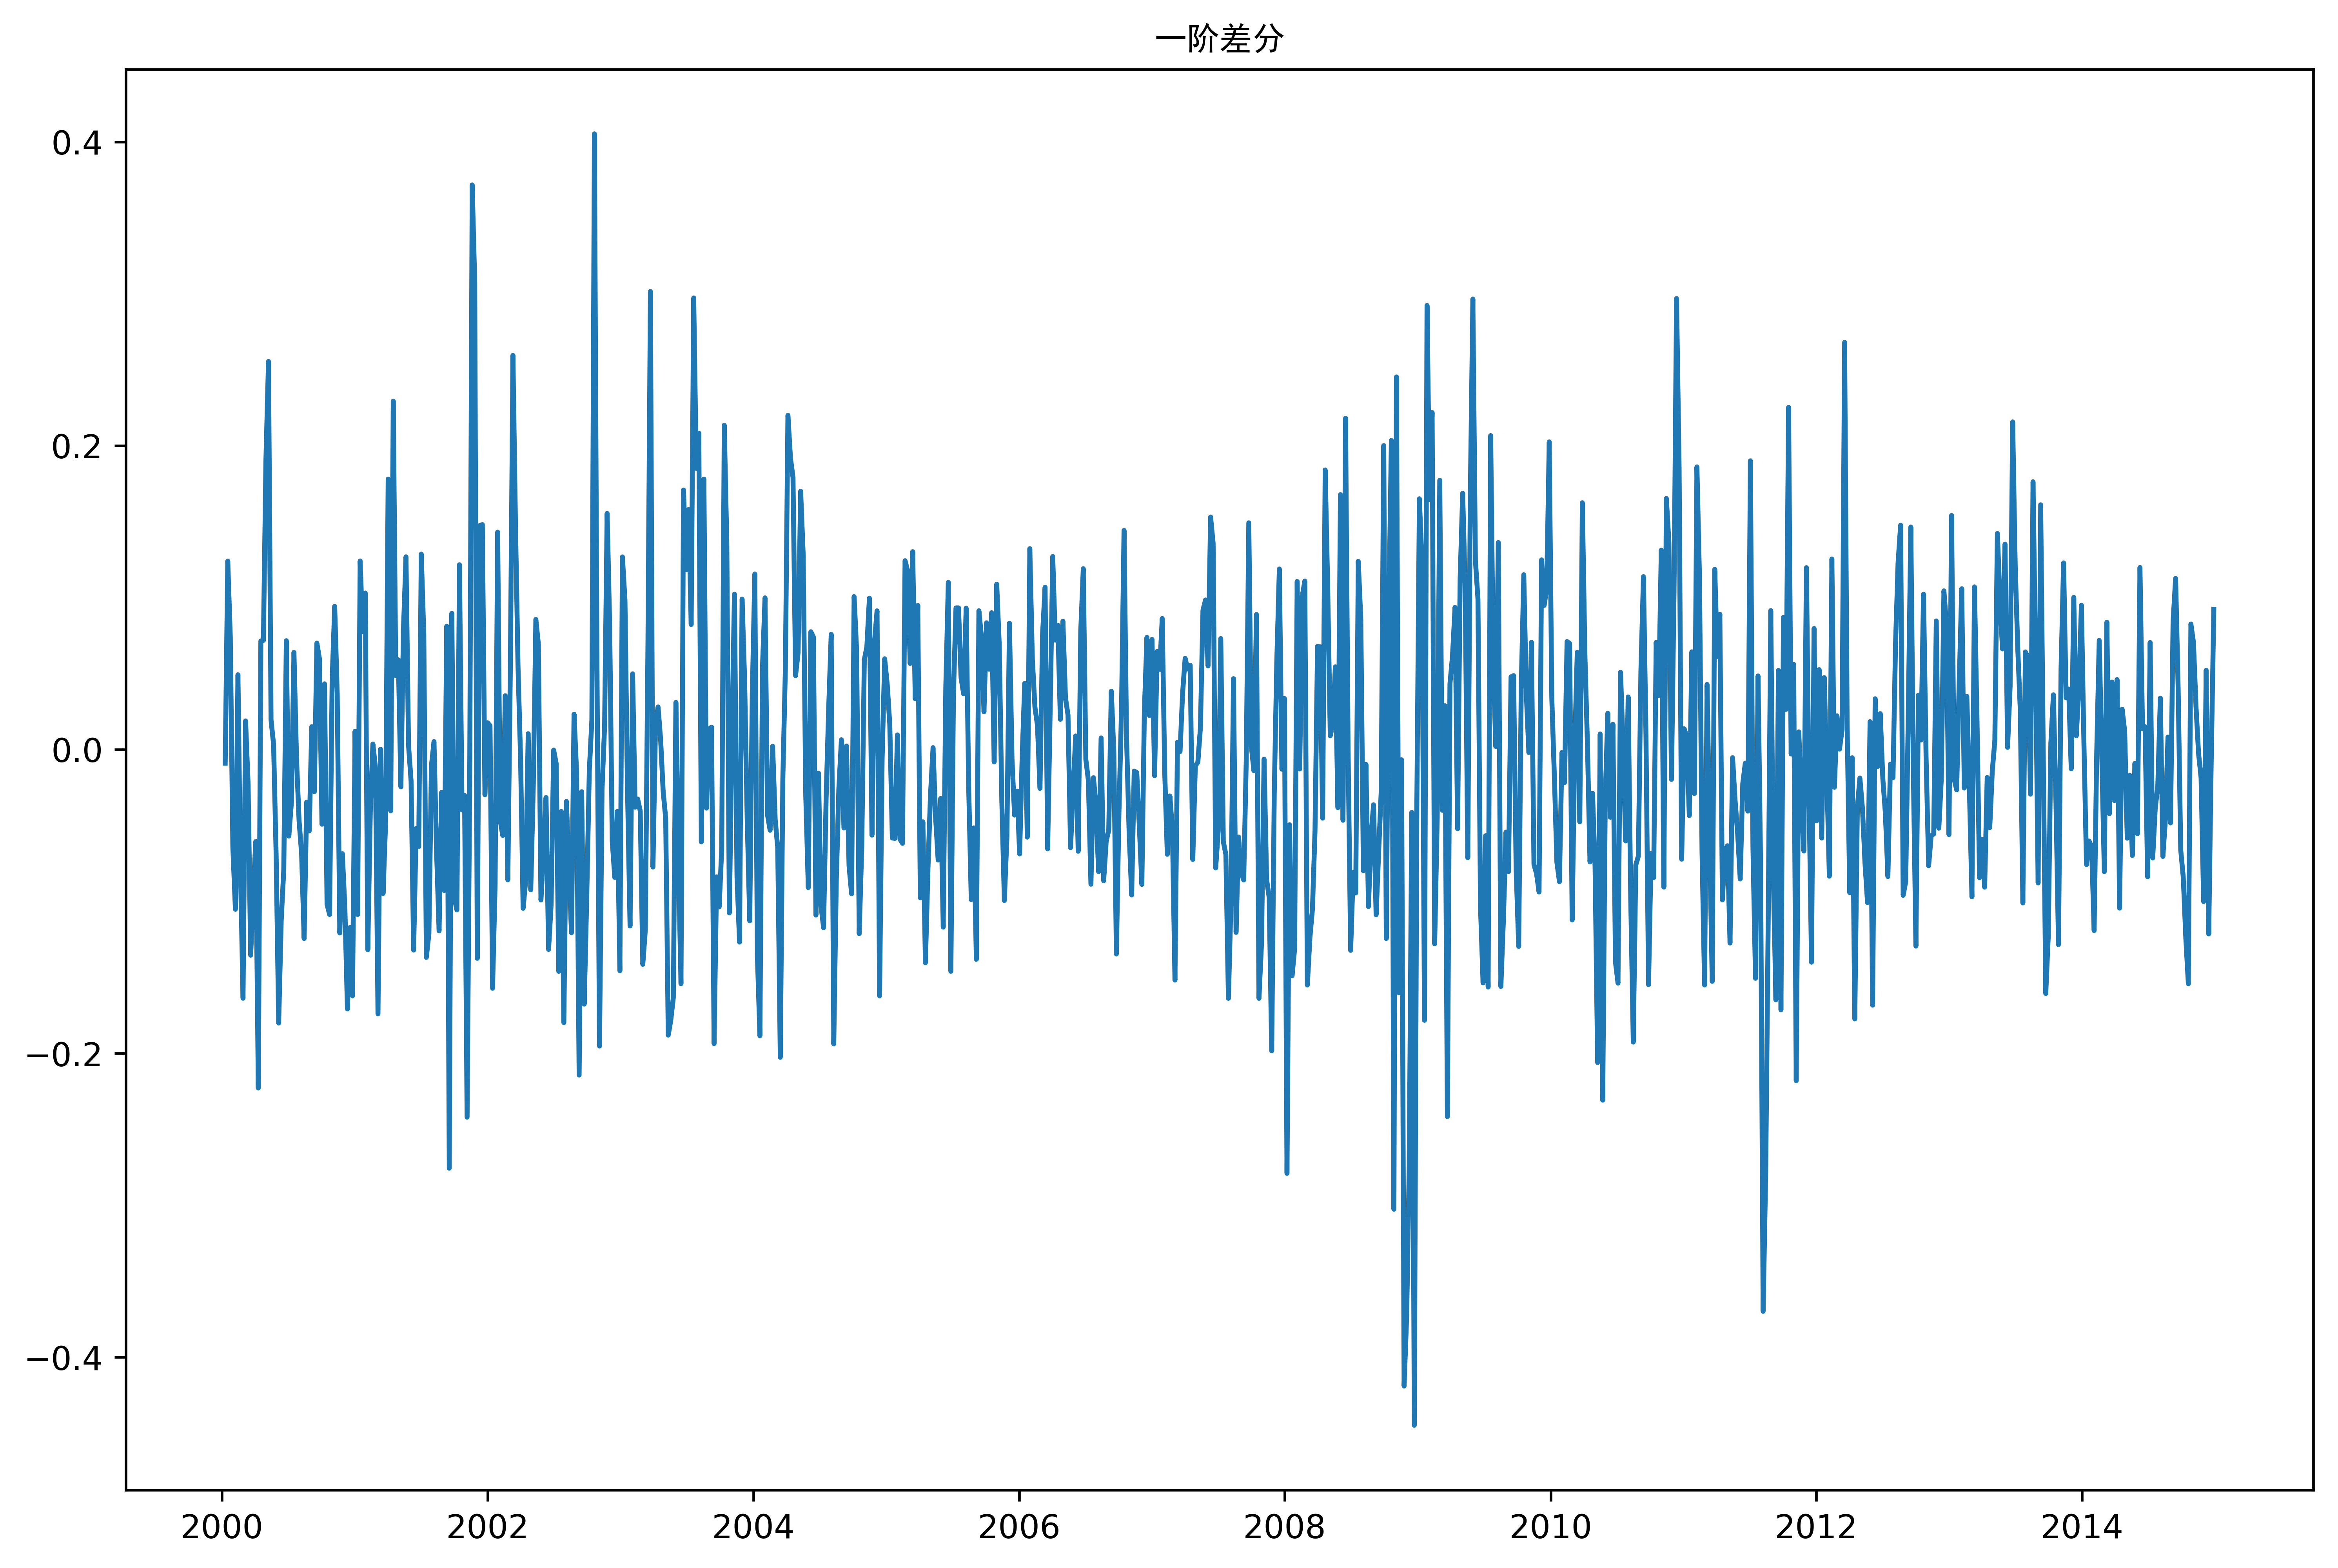

In [11]:
# 一阶差分图，前面已经注释，不再赘述
plt.figure(figsize=(12,8),dpi=600)
plt.plot(stock_diff)
plt.title('一阶差分',fontproperties=myfont)
plt.show()

In [12]:
#再次adf检验
from statsmodels.tsa.stattools import adfuller 
dftest = adfuller(stock_diff)
dftest[1]
#P_value接近0，暂时可判断平稳，但还要研究ACF和PACF

0.0

* 现在应该研究一阶差分序列的自相关图和偏自相关图，判断是否截尾

<Figure size 3600x2400 with 0 Axes>

Text(0.5, 1.0, 'ACF')

Text(0.5, 0, '阶数')

Text(0, 0.5, '自相关系数')

<Figure size 3600x2400 with 0 Axes>

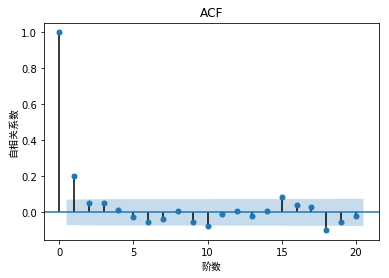

In [13]:
#ACF函数用来度量时间序列中每隔 k 个时间单位（yt 和 yt–k）的观测值之间的相关。
#展示自相关图,可以看出自相关图一阶截尾，所以q = 1
plt.figure(dpi=600)
acf = plot_acf(stock_diff, lags=20)
plt.title("ACF")
plt.xlabel("阶数",fontproperties=myfont)
plt.ylabel("自相关系数",fontproperties=myfont)
acf.show()

<Figure size 3600x2400 with 0 Axes>

Text(0.5, 1.0, 'PACF')

Text(0.5, 0, '阶数')

Text(0, 0.5, '偏自相关系数')

<Figure size 3600x2400 with 0 Axes>

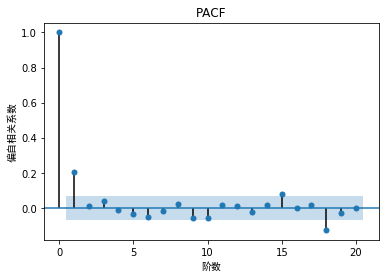

In [14]:
# 展示偏自相关图,结合自相关图，可以认为一阶差分偏自相关图一阶截尾 p = 1
plt.figure(dpi=600)
pacf = plot_pacf(stock_diff, lags=20)
plt.title("PACF")
plt.xlabel("阶数",fontproperties=myfont)
plt.ylabel("偏自相关系数",fontproperties=myfont)
pacf.show()#展示

# 可以用两种方式确定模型参数
* 通过观察ACF和PACF图
* 也可以用信息准则定阶，源码用的是AIC，算出适合的AR和MA阶数

In [17]:
import statsmodels.api as sm
#用AIC求解模型
res = sm.tsa.arma_order_select_ic(stock_diff,max_ar = 5,max_ma = 5,ic = ['aic']) 
res.aic_min_order
#确定模型阶数为AR:2,MA:3

(2, 3)

In [18]:
# ARIMA（p,d,q）通过ACF和PACF图确定系数
model = ARIMA(stock_train, order = (1,1,1),freq='W-MON')
result_1 = model.fit()

做预测然后画图

In [22]:
pred_1 = result_1.predict('2014-06-09', '2016-06-27',dynamic=True, typ='levels') 
print (pred_1)

2014-06-09    2.463146
2014-06-16    2.454620
2014-06-23    2.448235
2014-06-30    2.442495
2014-07-07    2.436947
                ...   
2016-05-30    1.895959
2016-06-06    1.890495
2016-06-13    1.885031
2016-06-20    1.879567
2016-06-27    1.874103
Freq: W-MON, Length: 108, dtype: float64


<Figure size 3600x2400 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

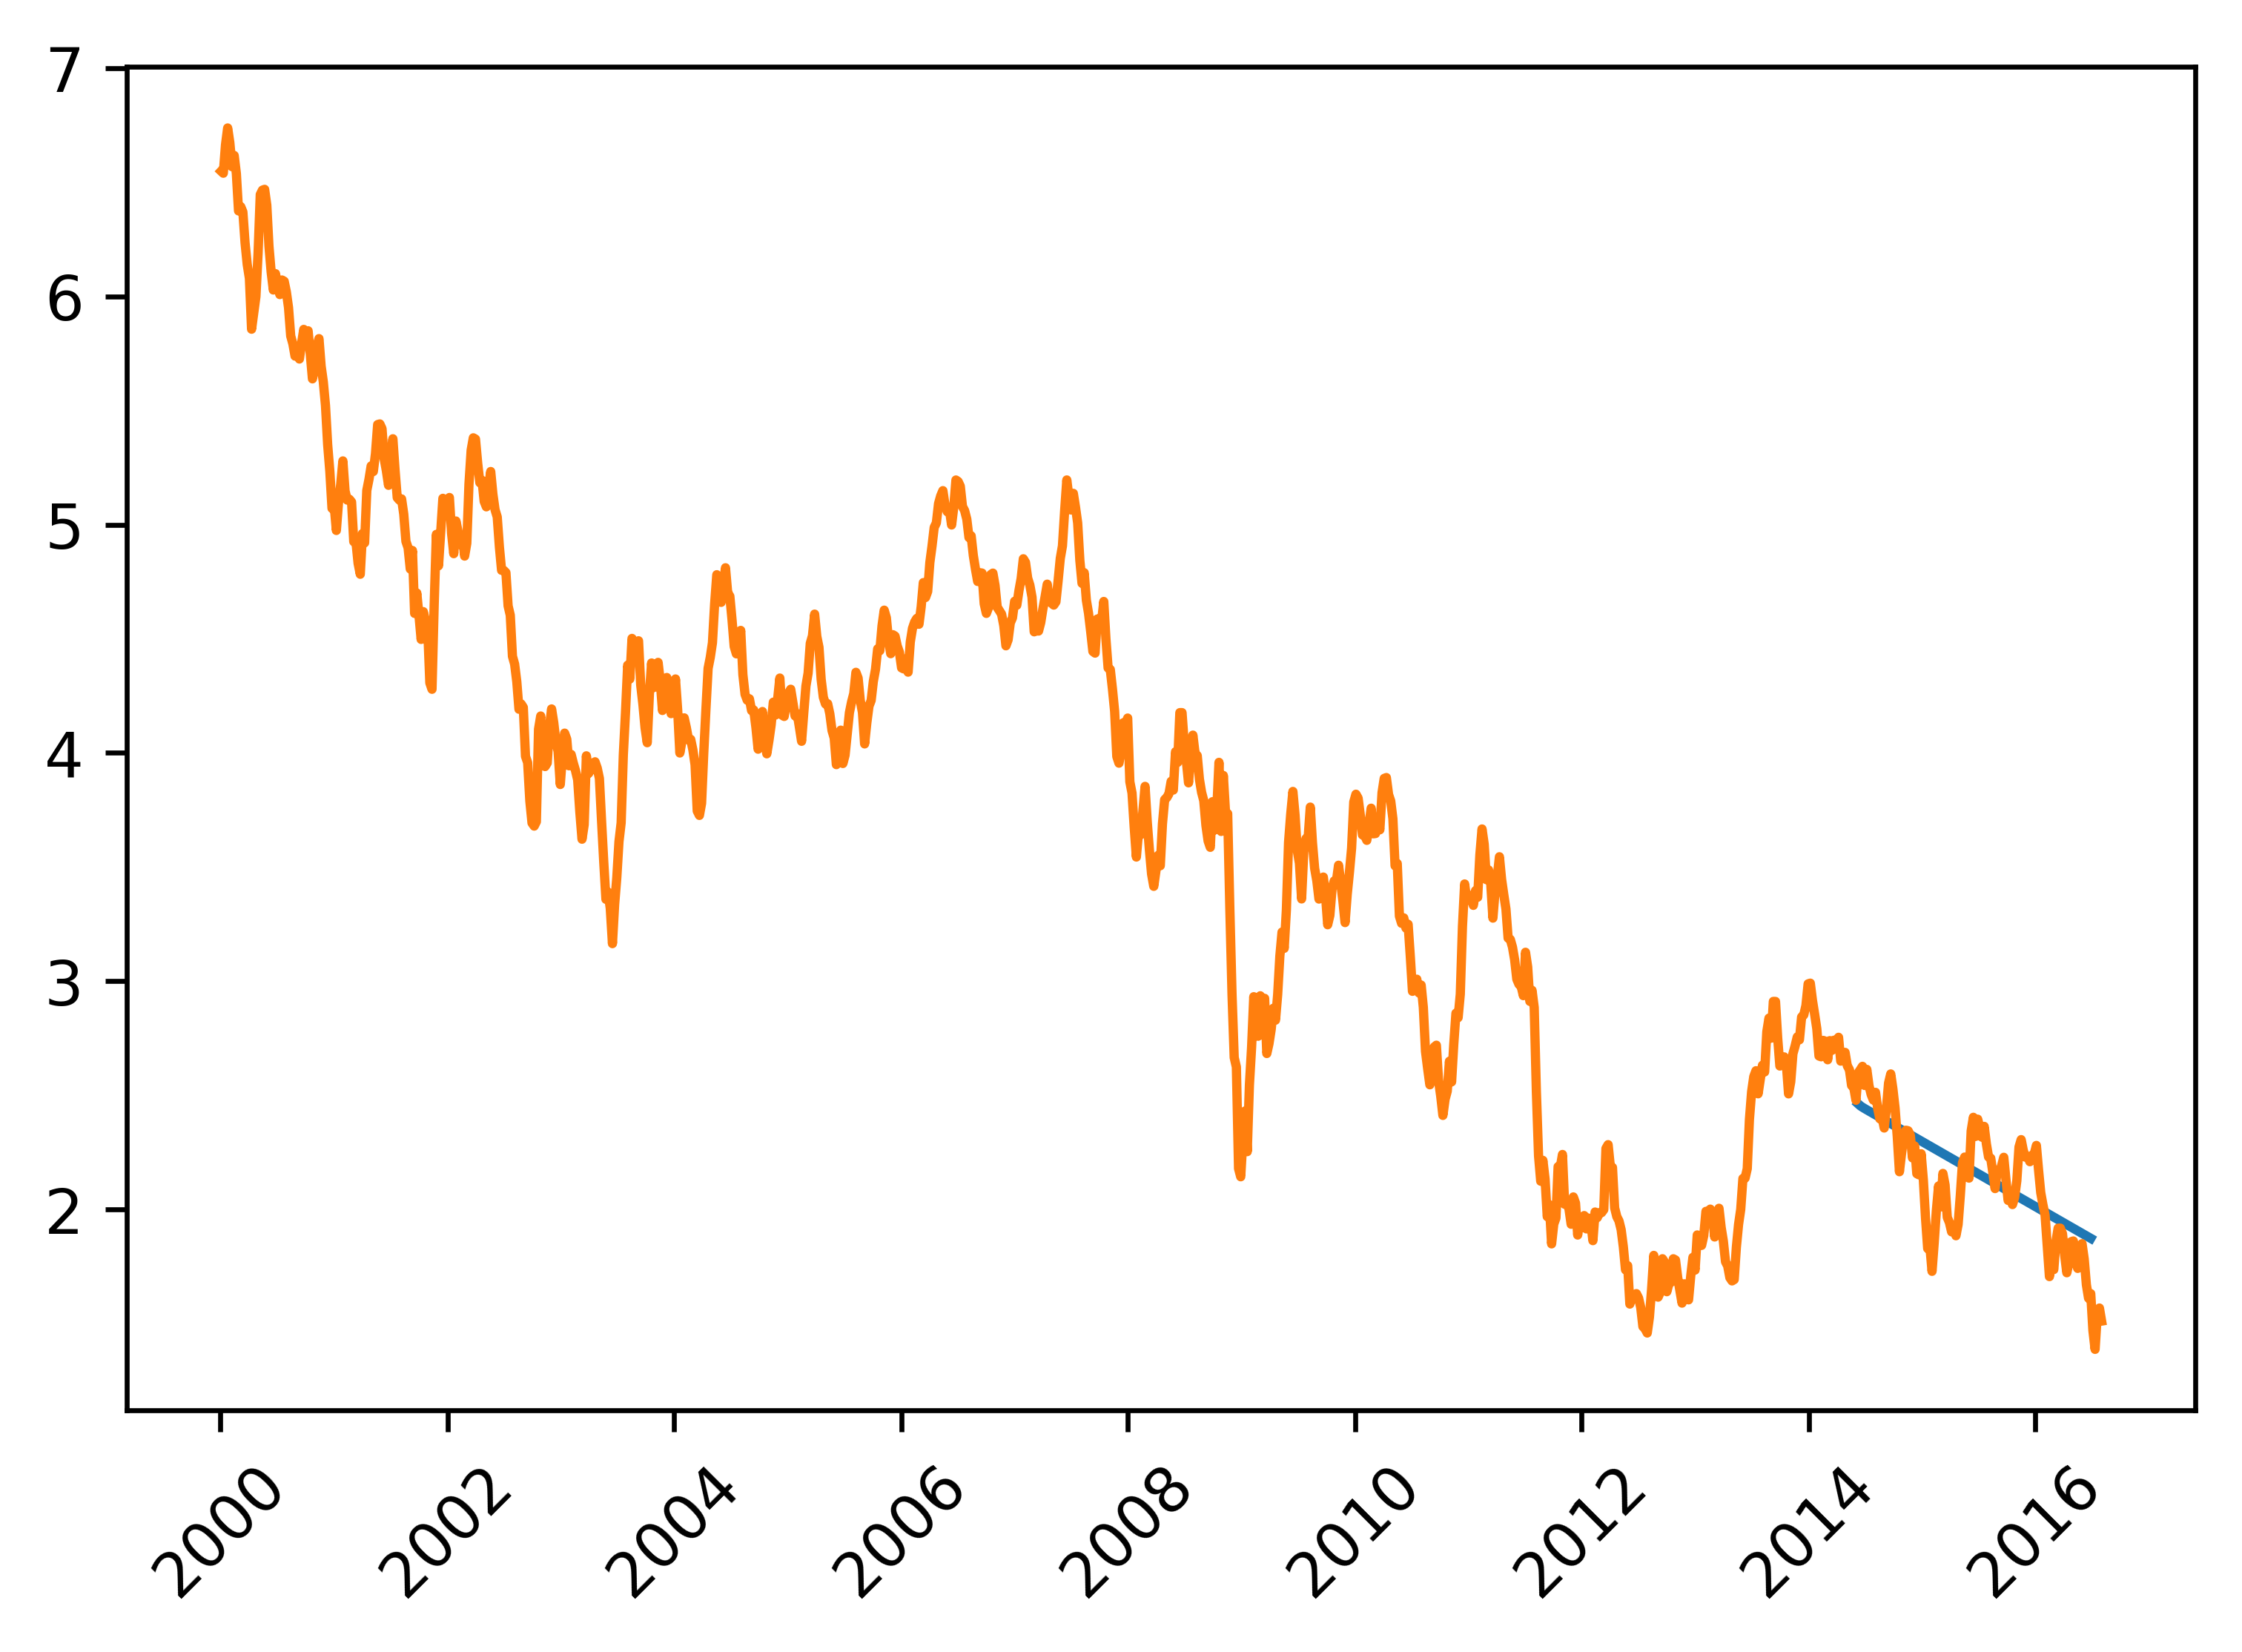

In [23]:
plt.figure(dpi=600)
#rotation旋转一下，没啥意义
plt.xticks(rotation=45) 
plt.plot(pred_1) 
plt.plot(stock_week) 

In [24]:
#通过AIC确定参数
model = ARIMA(stock_train, order = (2,1,3),freq='W-MON')
result_2 = model.fit()

做预测，画图

In [25]:
pred_2 = result_2.predict('20140609', '20160627',dynamic=True, typ='levels') 
print (pred_2)

2014-06-09    2.487238
2014-06-16    2.497337
2014-06-23    2.485452
2014-06-30    2.456166
2014-07-07    2.426347
                ...   
2016-05-30    1.928046
2016-06-06    1.905457
2016-06-13    1.878058
2016-06-20    1.861340
2016-06-27    1.863188
Freq: W-MON, Length: 108, dtype: float64


<Figure size 3600x2400 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

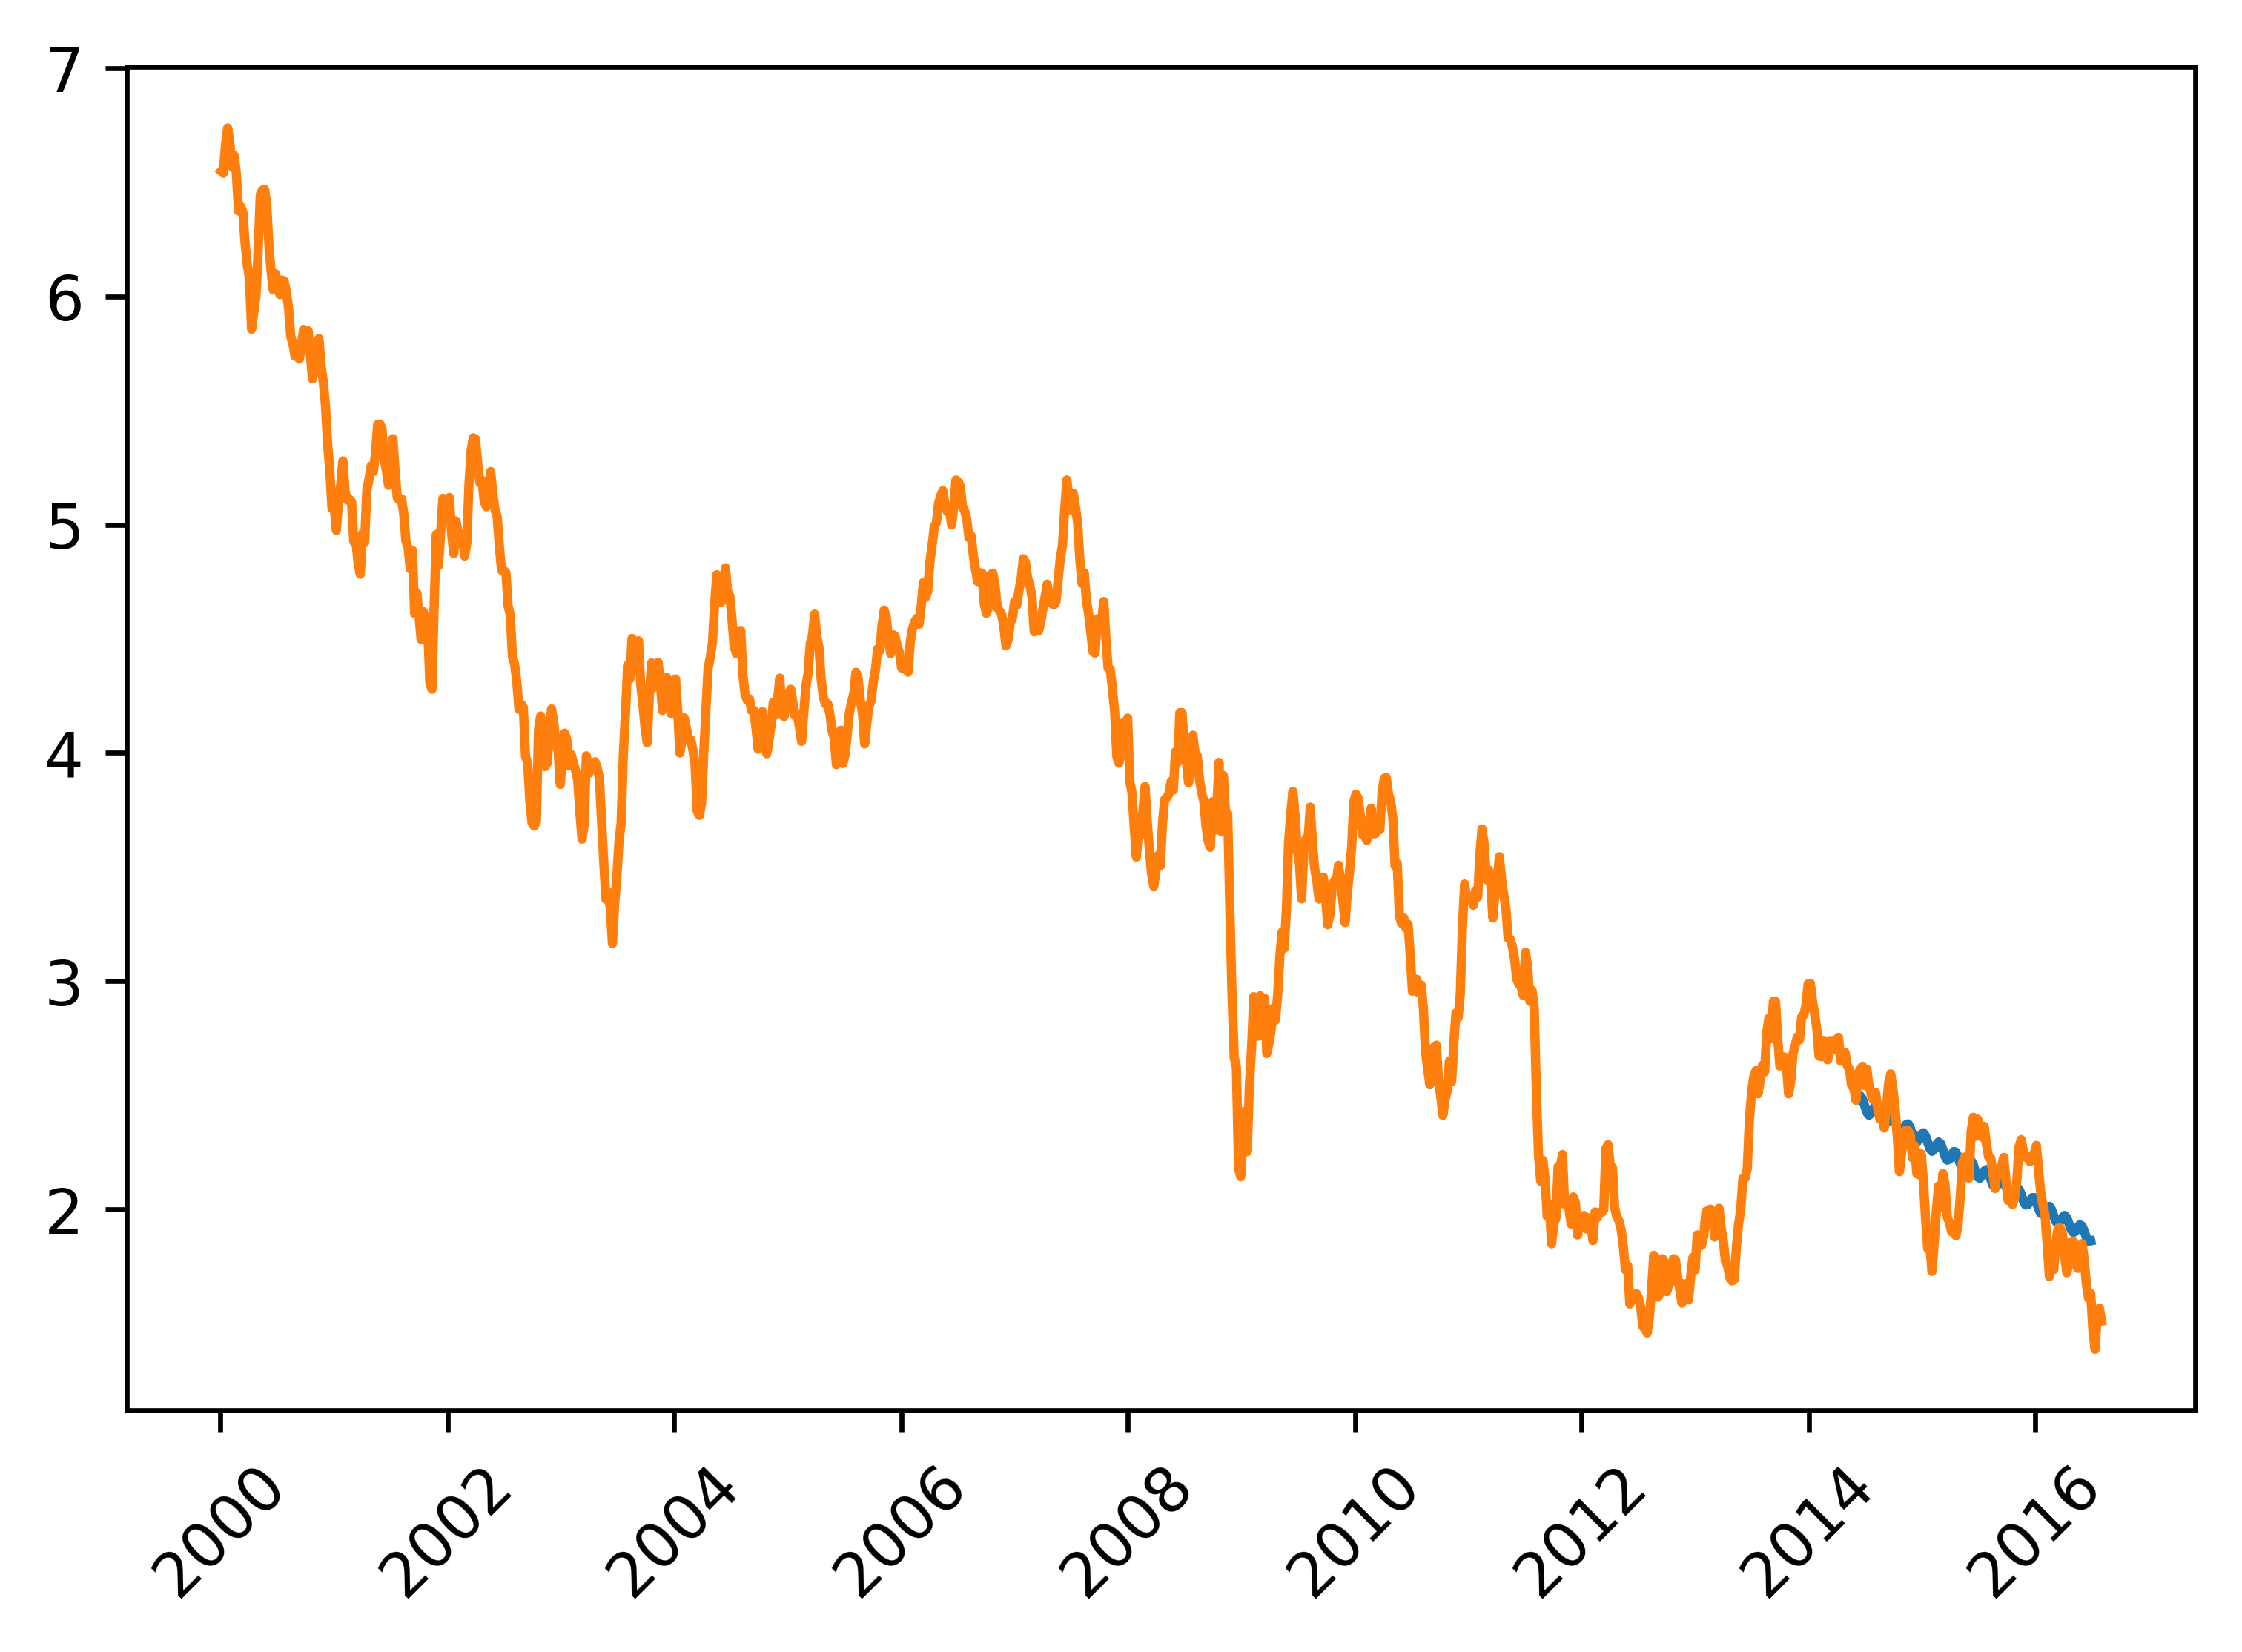

In [26]:
plt.figure(dpi=600)
plt.xticks(rotation=45)
plt.plot(pred_2) 
plt.plot(stock_week) 

In [27]:
#提取测试集
stock_actual = stock_week['20140609':'20160627']
print(stock_actual)

日期
2014-06-09    2.59860
2014-06-16    2.61240
2014-06-23    2.62740
2014-06-30    2.54360
2014-07-07    2.61400
               ...   
2016-05-30    1.85075
2016-06-06    1.78360
2016-06-13    1.67080
2016-06-20    1.61180
2016-06-27    1.63200
Freq: W-MON, Name: 收盘价, Length: 108, dtype: float64


In [28]:
print(pred_1)

2014-06-09    2.463146
2014-06-16    2.454620
2014-06-23    2.448235
2014-06-30    2.442495
2014-07-07    2.436947
                ...   
2016-05-30    1.895959
2016-06-06    1.890495
2016-06-13    1.885031
2016-06-20    1.879567
2016-06-27    1.874103
Freq: W-MON, Length: 108, dtype: float64


In [29]:
# 算出残差
error_1=pow(stock_actual-pred_1,2)
# 算出均方误差
MSE1=error_1.sum()/len(pred_1)
print(MSE1)

0.032254007389797806


同理

In [30]:
print(pred_2)

2014-06-09    2.487238
2014-06-16    2.497337
2014-06-23    2.485452
2014-06-30    2.456166
2014-07-07    2.426347
                ...   
2016-05-30    1.928046
2016-06-06    1.905457
2016-06-13    1.878058
2016-06-20    1.861340
2016-06-27    1.863188
Freq: W-MON, Length: 108, dtype: float64


In [31]:
error_2=pow(stock_actual-pred_2,2)
MSE2=error_2.sum()/len(pred_2)
print(MSE2)

0.03234166811012275


算出均方误差分别为：0.032254007389797806和0.03234166811012275
* 差的不多，和0也很接近，说明结果还不错